In [1]:
import importlib as imp
import spotiphy
import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spotiphy
import seaborn as sns

In [2]:
adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/ST_Simulated1.h5ad")
adata_st.uns['spatial']['NCF221-D']['scalefactors']['tissue_hires_crop_scalef'] = 0.2
type_list = adata_st.uns['type_list']
results_folder = 'results/Simulation1/evaluation/'
data_folder = 'results/Simulation1/evaluation/deconvolution/'
type_list_RCTD = [s.replace('/', '') for s in type_list]
type_list_RCTD = [s.replace(' ', '.') for s in type_list_RCTD]

cell_count_truth = adata_st.obsm['ground_truth']
selected_spot = np.sum(cell_count_truth, axis=1)>0
proportion_truth = cell_count_truth[selected_spot]/np.sum(cell_count_truth[selected_spot], axis=1, keepdims=True)+1e-9

In [4]:
proportion_spotiphy = np.load(data_folder+'proportion_Sp.npy')
proportion_tangram = np.load(data_folder+'proportion_Tg.npy')
proportion_c2l = np.load(data_folder+'proportion_c2l.npy')
proportion_CARD = pd.read_csv(data_folder+'Proportion_CARD.csv', index_col=0, header=0)
proportion_CARD = proportion_CARD.reindex(adata_st.obs_names)
proportion_CARD = proportion_CARD[type_list].values
proportion_CARD[np.isnan(proportion_CARD)] = 1/proportion_CARD.shape[1]
proportion_cyto = pd.read_csv(data_folder+'Proportion_Cyto.csv', index_col=0, header=0)
proportion_cyto = proportion_cyto.reindex(adata_st.obs_names)
proportion_cyto = proportion_cyto[type_list].values
proportion_RCTD = pd.read_csv(data_folder+'Proportion_RCTD.csv', index_col=0, header=0)
proportion_RCTD = proportion_RCTD.reindex(adata_st.obs_names)
proportion_RCTD = proportion_RCTD[type_list_RCTD].values
proportion_RCTD[proportion_RCTD<0] = 0
proportion_RCTD = proportion_RCTD + 1e-9

methods = ['Spotiphy', 'Cell2location', 'CytoSPACE', 'CARD', 'Tangram', 'RCTD']
proportion_estimated = [proportion_spotiphy, proportion_c2l, proportion_cyto, proportion_CARD, proportion_tangram,
                        proportion_RCTD]
proportion_estimated = [p[selected_spot] for p in proportion_estimated]
proportion_dict = {k:v for k, v in zip(methods, proportion_estimated)}
adata_st = adata_st[selected_spot]

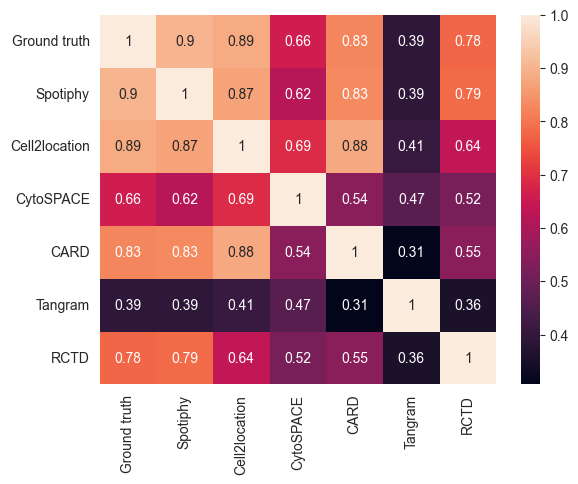

In [5]:
proportion_agg = [proportion_truth.flatten()] + [proportion.flatten() for proportion in proportion_estimated]
proportion_agg = np.vstack(proportion_agg)
corr_matrix = np.corrcoef(proportion_agg)
plt.grid(False)
sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
plt.savefig(results_folder+'correlation_all', dpi=400, bbox_inches = 'tight')

In [ ]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder)
metrics = ['Cosine similarity', 'Absolute error', 'Square error', 'Correlation', 'Fraction of cells correctly mapped',
           'JSD']
for metric in metrics:
    Eval.plot_metric(save=True, metric=metric, metric_type='Spot')
    Eval.plot_metric(save=True, metric=metric, metric_type='Cell type')

In [19]:
Eval.metric_dict['JSD Cell type']

[array([0.11110833, 0.5600817 , 0.27084792, 0.3480356 , 0.25957681,
        0.23217664, 0.60505614, 0.73754322, 0.32797552, 0.451416  ,
        0.44452491, 0.79972698, 0.52216818, 0.7533376 , 0.58489897,
        0.63694172, 0.7475479 , 0.16479849, 0.28877963, 0.26238372,
        0.18399986, 0.58384422, 0.76921808, 0.76599785, 0.16087242,
        0.15591104, 0.81135866]),
 array([0.10501917, 0.35915283, 0.43748926, 0.505299  , 0.51216001,
        0.3356827 , 0.73511703, 0.79269495, 0.47911425, 0.65801123,
        0.56880373, 0.825226  , 0.71644572, 0.80370811, 0.73786535,
        0.78949055, 0.81335906, 0.30137297, 0.38808353, 0.14283377,
        0.31503498, 0.71817239, 0.82137262, 0.80841784, 0.39228318,
        0.29200493, 0.82741014]),
 array([0.64610859, 0.7288621 , 0.53679669, 0.55786522, 0.6886139 ,
        0.49571354, 0.59916665, 0.70867785, 0.61203794, 0.67739286,
        0.61882358, 0.82876753, 0.42551371, 0.7254396 , 0.56046795,
        0.81386053, 0.79928169, 0.65583922, 0.81

In [11]:
np.any(np.isnan(proportion_RCTD))

False

In [ ]:
type_list_truth = [type +'_truth' for type in type_list]
adata_st.obs[type_list_truth] = proportion_truth
type_list_method = []
for method in methods:
    type_list_method.append([type +'_' + method for type in type_list])
    adata_st.obs[type_list_method[-1]] = proportion_dict[method]

In [19]:
%matplotlib agg
%matplotlib agg
vmax = np.quantile(adata_st.obs[type_list_truth].to_numpy(), 0.98, axis=0)
vmax[vmax < 0.05] = 0.05
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 800}):
    for j, method in enumerate(methods):
        for i, cell_type in enumerate(type_list):
            ax = sc.pl.spatial(adata_st, cmap='magma', color=cell_type+'_'+method, img_key='hires', vmin=0, vmax=vmax[i],
                               size=1.3, show=False)
            cell_type = "".join(x for x in cell_type if x.isalnum())
            ax[0].get_figure().savefig(results_folder+'deconvolution figure/'+method+'/'+cell_type+'.jpg')

In [34]:
celltype_group = [['L2/3 IT CTX', 'L4 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 IT CTX', 'L5/6 NP CTX',
                   'L6 CT CTX', 'L6 IT CTX', 'L6b CTX', 'CA', 'DG', 'SUB', 'Pvalb', 'Lamp5'],
                  ['Astro', 'Oligo'],
                  ['Microglia']]
idx = 0
celltype_select = celltype_group[idx]
celltype_idx = np.array([list(type_list).index(cell_type) for cell_type in celltype_select])

In [ ]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth[:, celltype_idx],
                                         [p[:, celltype_idx] for p in proportion_estimated],
                                         methods, out_dir=results_folder)
for metric in metrics:
    Eval.plot_metric(save=True, metric=metric, metric_type='Spot')
    Eval.plot_metric(save=True, metric=metric, metric_type='Cell type')

([<matplotlib.axis.XTick at 0x23d076d6b50>,
 [Text(0, 0, 'L2/3 IT CTX'),
  Text(1, 0, 'L4 IT CTX'),
  Text(2, 0, 'L4/5 IT CTX'),
  Text(3, 0, 'L5 IT CTX'),
  Text(4, 0, 'L5 PT CTX'),
  Text(5, 0, 'L5/6 IT CTX'),
  Text(6, 0, 'L5/6 NP CTX'),
  Text(7, 0, 'L6 CT CTX'),
  Text(8, 0, 'L6 IT CTX'),
  Text(9, 0, 'L6b CTX'),
  Text(10, 0, 'CA'),
  Text(11, 0, 'DG'),
  Text(12, 0, 'SUB'),
  Text(13, 0, 'Pvalb'),
  Text(14, 0, 'Lamp5')])

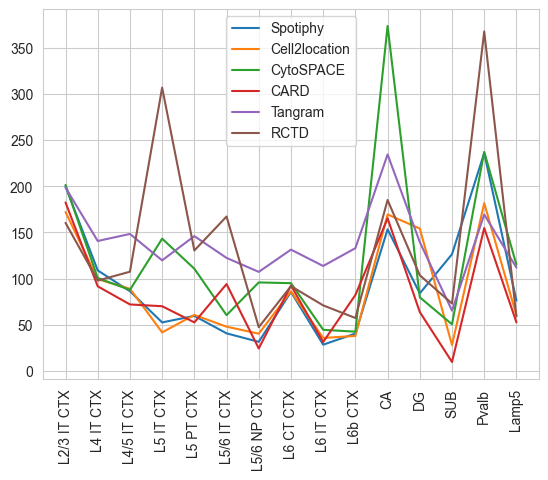

In [37]:
for i, method in enumerate(methods):
    plt.plot(Eval.metric_dict['Absolute error Cell type'][i])
plt.legend(methods)
plt.xticks(np.arange(len(celltype_group[idx])), celltype_group[idx], rotation=90)

In [ ]:
for i, cell_type in enumerate(type_list):
    proportion_agg = [proportion_truth[:, i]+1e-8] + [proportion[:, i]+1e-8 for proportion in proportion_estimated]
    proportion_agg = np.vstack(proportion_agg)
    corr_matrix = np.corrcoef(proportion_agg)
    plt.figure(figsize=(7, 6))
    plt.grid(False)
    plt.title(cell_type)
    sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
    cell_type = "".join(x for x in cell_type if x.isalnum())
    plt.savefig(results_folder+'extra figures/correlation_'+cell_type+'.png', dpi=400, bbox_inches = 'tight')